# Phi-4 model

In [1]:
using Statistics
using Plots
using StatsBase

# Define functions 

In [13]:
ppal_dir = pwd()

function init_lattice(L, theta, xi)
   
    lattice = zeros((L,L))
    
    phi_eq = sqrt(theta / xi)
    
    for i in 1:L
        for j in 1:L
            
            lattice[i,j] = phi_eq
            
        end
    end
        
    return lattice
    
end

function interaction(i, j, lattice, L)
    
    u = 1 + mod(j, L)   # up
    d = 1 + mod(j-2,L) # down
    r = 1 + mod(i, L)   # right
    l = 1 + mod(i-2, L) # left
    
    c = lattice[i,u] + lattice[i,d] + lattice[l,j] + lattice[r,j]
    
    return c
    
end

function compute_Ms(lattice, L)
    
    M_0 = 0.
    M_1 = 0.
    M_2 = 0.
    M_3 = 0.
    
    for i in 1 : L
        for j in 1 : L
            
            M_0 += lattice[i,j]
            M_1 += lattice[i,j]^2
            M_2 += lattice[i,j]^4
            
            u = 1 + mod(j, L)   # up
            d = 1 + mod(j-2,L) # down
            r = 1 + mod(i, L)   # right
            l = 1 + mod(i-2, L) # left
            
            #M_3 += ((lattice[i,u]-lattice[i,j])^2 + (lattice[i,d]-lattice[i,j])^2  + (lattice[l,j]-lattice[i,j])^2 + (lattice[r,j]-lattice[i,j])^2)
            
            M_3 += ((lattice[i,u]-lattice[i,j])^2 + (lattice[r,j]-lattice[i,j])^2)
            
            
            #M_3 += interaction(i, j, lattice, L) * lattice[i,j]
            
        end
        
    end
            
    return abs(M_0), M_1, M_2, M_3
    
end

function heat_bath(lattice, i, j, a, b, L)
    
    c = interaction(i, j, lattice, L)
    
    mu = c / (2*a)
    sigma = sqrt(1 /(2*a))
    
    gaussian_number = sigma * randn() + mu
    dice = rand()
    
    #With repetition
    while dice > exp(-b*gaussian_number^4)
            
            gaussian_number = sigma * randn() + mu
            dice = rand()

    end

    lattice[i,j] = gaussian_number
    
    #Without repetition
    #=
    if dice < exp(-b*gaussian_number^4)
        
        lattice[i,j] = gaussian_number
        
    end
    =#
    
    return lattice
    
end

function simulation(L, theta, xi, t, eq_time, K, lattice)
    
    a = 2 - theta / 2
    b = xi / 4
   
    M_0_t = zeros(t)
    M_1_t = zeros(t)
    M_2_t = zeros(t)
    M_3_t = zeros(t)
    
    #Thermalisation
    for MCS in 1 : eq_time

        for i in 1 : L
            for j in 1 : L
            
                lattice = heat_bath(lattice, i, j, a, b, L)
                
            end
        end
            
    end
    
    #Calculation
    for MCS in 1 : t

        for k in 1 : K
        
            for i in 1 : L
                for j in 1 : L

                    lattice = heat_bath(lattice, i, j, a, b, L)

                end
            end
            
        end
        
        M_0, M_1, M_2, M_3 = compute_Ms(lattice, L)

        @inbounds M_0_t[MCS] = M_0
        @inbounds M_1_t[MCS] = M_1
        @inbounds M_2_t[MCS] = M_2
        @inbounds M_3_t[MCS] = M_3
        
    end
    
    return M_0_t, M_1_t, M_2_t, M_3_t
        
end

function exp_corr(array)
    
    length = size(array)[1]
    corr = 0.
    
    for i in 1 : length - 1
        
        corr += array[i] * array[i + 1]
        
    end
        
    x = corr / length
    
    rho = (x - mean(array)^2) / var(array)
    
    final_corr = rho / (1 - rho)
    
    return final_corr
    
end

function avg_error(array)
    
    avg = mean(array)
    
    tau = exp_corr(array)
    
    L = length(array)
    
    if tau > 0
    
        error = sqrt(var(array) / L) * sqrt(2 * tau + 1)
        
    else
        
        error = sqrt(var(array) / L)
        
    end
    
    return (avg, error)
    
end

function simulate(L, xi, theta, t, eq_time, K)
   
    lattice = init_lattice(L, theta, xi)
    
    Ms = simulation(L, theta, xi, t, eq_time, K, lattice)
    
    return Ms
    
end

function simulate_2(L, xi, theta_1, theta_2, t, eq_time, K)
   
    #First simulation
    lattice = init_lattice(L, theta_1, xi)
    
    Ms_1 = simulation(L, theta_1, xi, t, eq_time, K, lattice)
 
    #Second simulation
    lattice = init_lattice(L, theta_2, xi)
    
    Ms_2 = simulation(L, theta_2, xi, t, eq_time, K, lattice)
    
    return Ms_1, Ms_2
    
end

function Ferrenberg_Swendsen(theta, xi, Ms, L, d_theta)
    
    t = length(Ms[1])
    sigma_M_1 = var(Ms[2])
    
    max_delta_theta = 2 / sqrt(sigma_M_1)
    
    extrapolation_thetas = collect(theta - max_delta_theta : d_theta : theta + max_delta_theta)
    
    new_ms = zeros(length(extrapolation_thetas))
    new_es = zeros(length(extrapolation_thetas))
    new_kappa = zeros(length(extrapolation_thetas))
    new_C = zeros(length(extrapolation_thetas))
    
    i = 0
    
    for theta_prime in extrapolation_thetas
        
        i += 1
        
        num_M_0 = 0.
        num_M_1 = 0.
        num_M_2 = 0.
        num_M_3 = 0.
        
        denom = 0.
        
        num_M_squared = 0.
        num_E_squared = 0.
        
        for k in 1 : t
                    
            #Ms
            num_M_0 += Ms[1][k] * exp((theta_prime - theta) / 2 * Ms[2][k])
            num_M_1 += Ms[2][k] * exp((theta_prime - theta) / 2 * Ms[2][k])
            num_M_2 += Ms[3][k] * exp((theta_prime - theta) / 2 * Ms[2][k])
            num_M_3 += Ms[4][k] * exp((theta_prime - theta) / 2 * Ms[2][k])
            
            denom += exp((theta_prime - theta) / 2 * Ms[2][k])
            
            #M^2
            num_M_squared += Ms[1][k]^2 * exp((theta_prime - theta) / 2 * Ms[2][k])
            
            #E^2
            E_squared = (-theta_prime * Ms[2][k] / 2 + xi * Ms[3][k] / 4 + Ms[4][k] / 2)^2
            
            num_E_squared += E_squared * exp((theta_prime - theta) / 2 * Ms[2][k])
            
        end
    
        M_1 = num_M_1 / denom
        M_2 = num_M_2 / denom
        M_3 = num_M_3 / denom
        
        #M and M^2
        new_M = num_M_0 / denom
        new_M_squared = num_M_squared / denom
        
        new_ms[i] = new_M / L^2
        new_kappa[i] = (new_M_squared - new_M^2) / L^2
        
        #E and E^2
        new_E = (-theta_prime * M_1 / 2 + xi * M_2 / 4 + M_3 / 2)
        new_E_squared = num_E_squared / denom
        
        new_es[i] = new_E / L^2
        new_C[i] = (new_E_squared - new_E^2) / L^2
        
    end
            
    return new_ms, new_es, new_kappa, new_C, extrapolation_thetas
    
end    
  
function study_delta_theta(Ls, xi)
    
    theta = 1.26
    t = 10^6
    eq_time = 10^5
    K = 1
    
    max_deltas = zeros(length(Ns))
    
    f = open("max_delta_theta_study.txt", "w")
    
    println(f, "#L\tmax_delta\tsigma")
    println("#L\tmax_delta\tsigma")

    i = 0
    
    for L in Ls
        
        i += 1
        
        Ms = simulate(L, xi, theta, t, eq_time, K)
        
        sigma_M_1 = var(Ms[2])
    
        max_delta_theta = 2 / sqrt(sigma_M_1)
        
        max_deltas[i] = max_delta_theta
        
        println(L, "\t", max_delta_theta, "\t", sigma_M_1)
        println(f, L, "\t", max_delta_theta, "\t", sigma_M_1)
        
    end
    
    close(f)
   
    return max_deltas
    
end

function simulation_K(L, theta, xi, t, eq_time, lattice, tau_M)
    
    a = 2 - theta / 2
    b = xi / 4
   
    M_0_t = zeros(t)
    M_1_t = zeros(t)
    M_2_t = zeros(t)
    M_3_t = zeros(t)
    
    #Thermalisation
    for MCS in 1 : eq_time

        for i in 1 : L
            for j in 1 : L
            
                lattice = heat_bath(lattice, i, j, a, b, L)
                
            end
        end
            
    end
    
    time_MC = 0.
    time_measure = 0.
    
    #Calculation
    for MCS in 1 : t
        
        time_start = time_ns()

        for i in 1 : L
            for j in 1 : L

                lattice = heat_bath(lattice, i, j, a, b, L)

            end
        end
        
        time_MC = time_ns() - time_start
        
        time_start = time_ns()
            
        M_0, M_1, M_2, M_3 = compute_Ms(lattice, L)

        M_0_t[MCS] = M_0
        M_1_t[MCS] = M_1
        M_2_t[MCS] = M_2
        M_3_t[MCS] = M_3
        
        time_measure = time_ns() - time_start
        
        opt = sqrt(2*tau_M*time_measure/time_MC)
        
        println("L: ", L, "\t", "K_opt: ", opt)
        
    end
        
end


simulation_K (generic function with 1 method)

# Determine optimal K

This should be done for each $\chi$

In [3]:
#tau as function of L to determine the relation and compute optimal K's
function tau_L(Ls, theta, xi)
    
    t = 10^5
    eq_time = 10^5
    K = 1
    
    f = open("tau_M_L_study.txt", "w")
    
    println("#L\ttau_M")
    println(f, "#L\ttau_M")
    
    for L in Ls
        

        Ms = simulate(L, xi, theta, t, eq_time, K);
        
        tau = exp_corr(Ms[1])
        
        println(L, "\t", tau)
        println(f, L, "\t", tau)
        
    end
        
    close(f)
    
end

function optimal_K(Ns, theta, xi)
    
    t = 1
    eq_time = 0
    
    for L in Ls
        
        tau = 0.029 * L^2.276 + 19.32 #Determined previously (xi=1, theta=1.265)
        
        lattice = init_lattice(L, theta, xi)

        simulation_K(L, theta, xi, t, eq_time, lattice, tau)
        
    end
    
end

optimal_K (generic function with 1 method)

# Single-point simulation for different L's 

In [4]:
function N_simulation(Ls, Ks, xi, theta, t, eq_time)
    
    i = 0
    
    folder = "xi_$xi"
    
    if ! isdir(folder)
        mkdir(folder)
    end
    
    cd(folder)
    
    for L in Ls
        
        i += 1
        
        K = Ks[i]
   
        Ms = simulate(L, xi, theta, t, eq_time, K)
        
        f = open("L_$L.txt", "w")
        
        println(f, "#M_0\tM_1\tM_2\tM_3")
        
        for j in 1 : t
           
            println(f, Ms[1][j], "\t", Ms[2][j], "\t", Ms[3][j], "\t", Ms[4][j])
            
        end
        
        close(f)
        
        println("L: ", L, " done")
        
    end
    
    f = open("parameters_used.txt", "w")
    
    println(f, "Ks:\t", Ks)
    println(f, "theta:\t", theta)
    println(f, "t:\t", t)
    println(f, "eq_t:\t", eq_time)
    
    close(f)
    
    cd(ppal_dir)
    
end

N_simulation (generic function with 1 method)

# Ferrenberg and Swendsen extrapolation technique

In [5]:
function read_file_Ms(filename)
  
    f = open(filename, "r")

    lines = readlines(filename)

    M_0 = zeros(length(lines[2:end]))
    M_1 = zeros(length(lines[2:end]))
    M_2 = zeros(length(lines[2:end]))
    M_3 = zeros(length(lines[2:end]))

    i = 0

    for l in lines[2:end]

        i += 1

        line = split(l)

        M_0[i] = parse(Float64, line[1])
        M_1[i] = parse(Float64, line[2])
        M_2[i] = parse(Float64, line[3])
        M_3[i] = parse(Float64, line[4])
        
    end
    
    return M_0, M_1, M_2, M_3
    
end

function extrapolate_Ls(Ls, xi, theta, d_theta)
    
    folder = "xi_$xi"

    cd(folder)
    
    thetas_kappa = []
    thetas_C = []
    
    for L in Ls

        filename = "L_$L.txt"

        Ms = read_file_Ms(filename)

        new_ms, new_es, new_kappa, new_C, extrapolation_thetas = @time Ferrenberg_Swendsen(theta, xi, Ms, L, d_theta)

        #Find maximums of kappa and C
        
        max_kappa = maximum(new_kappa)
        max_C = maximum(new_C)
        
        for i in 1 : length(new_kappa)
           
            if new_kappa[i] == max_kappa
                
                append!(thetas_kappa, extrapolation_thetas[i])
                
            end
            
            if new_C[i] == max_C
            
                append!(thetas_C, extrapolation_thetas[i])
                
            end
        end
        
    end
    
    f = open("peaks.txt", "w")
    
    println(f, "#L\ttheta_kappa\ttheta_C")
    
    for i in 1 : length(thetas_kappa)
       
        println(f, Ls[i], "\t", thetas_kappa[i], "\t", thetas_C[i])
        
    end

    close(f)
    
    cd(ppal_dir)
            
end

extrapolate_Ls (generic function with 1 method)

# Run 2-point simulation 

In [6]:
#=
L = 40

xi = 0.01

theta_1 = 0.022
theta_2 = 0.026

t = 10^5
eq_time = 10^5

K = 1

Ms_1, Ms_2 = simulate_2(L, xi, theta_1, theta_2, t, eq_time, K);

#m
init_m_1 = avg_error(Ms_1[1]) ./ L^2
init_m_2 = avg_error(Ms_2[1]) ./ L^2

init_m_val_1 = init_m_1[1]
init_m_err_1 = init_m_1[2]

init_m_val_2 = init_m_2[1]
init_m_err_2 = init_m_2[2]

#e
init_e_val_1 = (-theta_1 * mean(Ms_1[2]) / 2 + xi * mean(Ms_1[3]) / 4 + mean(Ms_1[4]) / 2) / L^2
init_e_err_1 = sqrt(((-theta_2 * 0.5 * avg_error(Ms_1[2])[2])^2 + (xi * 0.25 * avg_error(Ms_1[3])[2])^2 + (0.5 * avg_error(Ms_1[4])[2])^2) / L^2)

init_e_val_2 = (-theta_2 * mean(Ms_2[2]) / 2 + xi * mean(Ms_2[3]) / 4 + mean(Ms_2[4]) / 2) / L^2
init_e_err_2 = sqrt(((-theta_2 * 0.5 * avg_error(Ms_2[2])[2])^2 + (xi * 0.25 * avg_error(Ms_2[3])[2])^2 + (0.5 * avg_error(Ms_2[4])[2])^2) / L^2)

#kappa and C

init_M_2_val_1 = zeros(length(Ms_1[1])) 
init_E_2_val_1 = zeros(length(Ms_1[1]))

init_M_2_val_2 = zeros(length(Ms_2[1])) 
init_E_2_val_2 = zeros(length(Ms_2[1]))

for k in 1 : length(Ms_1[1])
    
    init_M_2_val_1[k] = Ms_1[1][k]^2
    init_E_2_val_1[k] = (-theta_1 * Ms_1[2][k] / 2 + xi * Ms_1[3][k] / 4 + Ms_1[4][k] / 2)^2
    
    init_M_2_val_2[k] = Ms_2[1][k]^2
    init_E_2_val_2[k] = (-theta_2 * Ms_2[2][k] / 2 + xi * Ms_2[3][k] / 4 + Ms_2[4][k] / 2)^2
    
end

avg_M_2_1 = avg_error(init_M_2_val_1)
avg_E_2_1 = avg_error(init_E_2_val_1)

avg_M_2_2 = avg_error(init_M_2_val_2)
avg_E_2_2 = avg_error(init_E_2_val_2)

init_M_val_1 = init_m_val_1 * L^2
init_M_err_1 = init_m_err_1 * L^2

init_M_val_2 = init_m_val_2 * L^2
init_M_err_2 = init_m_err_2 * L^2

init_E_val_1 = init_e_val_1 * L^2
init_E_err_1 = init_e_err_1 * L^2

init_E_val_2 = init_e_val_2 * L^2
init_E_err_2 = init_e_err_2 * L^2

#kappa
init_kappa_val_1 = (avg_M_2_1[1] - init_M_val_1^2) / L^2
init_kappa_err_1 = sqrt(avg_M_2_1[2]^2 + 4 * init_M_val_1^2 * init_M_err_1^2) / L^2

init_kappa_val_2 = (avg_M_2_2[1] - init_M_val_2^2) / L^2
init_kappa_err_2 = sqrt(avg_M_2_2[2]^2 + 4 * init_M_val_2^2 * init_M_err_2^2) / L^2

#C
init_C_val_1 = (avg_E_2_1[1] - init_E_val_1^2) / L^2
init_C_err_1 = sqrt(avg_E_2_1[2]^2 + 4 * init_E_val_1^2 * init_E_err_1^2) / L^2

init_C_val_2 = (avg_E_2_2[1] - init_E_val_2^2) / L^2
init_C_err_2 = sqrt(avg_E_2_2[2]^2 + 4 * init_E_val_2^2 * init_E_err_2^2) / L^2
=#

10773.9835237518

# Run 1 point simulation 

In [14]:
L = 8

xi = 1.0

theta_1 = 1.265

t = 10^4
eq_time = 10^5

K = 1

Ms_1 = @time simulate(L, xi, theta_1, t, eq_time, K);

#m
init_m_1 = avg_error(Ms_1[1]) ./ L^2

init_m_val_1 = init_m_1[1]
init_m_err_1 = init_m_1[2]


#e
init_e_val_1 = (-theta_1 * mean(Ms_1[2]) / 2 + xi * mean(Ms_1[3]) / 4 + mean(Ms_1[4]) / 2) / L^2
init_e_err_1 = sqrt(((-theta_2 * 0.5 * avg_error(Ms_1[2])[2])^2 + (xi * 0.25 * avg_error(Ms_1[3])[2])^2 + (0.5 * avg_error(Ms_1[4])[2])^2) / L^2)

#kappa and C

init_M_2_val_1 = zeros(length(Ms_1[1])) 
init_E_2_val_1 = zeros(length(Ms_1[1]))

for k in 1 : length(Ms_1[1])
    
    init_M_2_val_1[k] = Ms_1[1][k]^2
    init_E_2_val_1[k] = (-theta_1 * Ms_1[2][k] / 2 + xi * Ms_1[3][k] / 4 + Ms_1[4][k] / 2)^2
    
end

avg_M_2_1 = avg_error(init_M_2_val_1)
avg_E_2_1 = avg_error(init_E_2_val_1)

init_M_val_1 = init_m_val_1 * L^2
init_M_err_1 = init_m_err_1 * L^2

init_E_val_1 = init_e_val_1 * L^2
init_E_err_1 = init_e_err_1 * L^2

#kappa
init_kappa_val_1 = (avg_M_2_1[1] - init_M_val_1^2) / L^2
init_kappa_err_1 = sqrt(avg_M_2_1[2]^2 + 4 * init_M_val_1^2 * init_M_err_1^2) / L^2

#C
init_C_val_1 = (avg_E_2_1[1] - init_E_val_1^2) / L^2
init_C_err_1 = sqrt(avg_E_2_1[2]^2 + 4 * init_E_val_1^2 * init_E_err_1^2) / L^2;

  0.867001 seconds (155.64 k allocations: 5.314 MiB, 0.81% gc time)


In [15]:
d_theta = 0.001

new_ms_1, new_es_1, new_kappa_1, new_C_1, extrapolation_thetas_1 = @time Ferrenberg_Swendsen(theta_1, xi, Ms_1, L, d_theta);
#new_ms_2, new_es_2, new_kappa_2, new_C_2, extrapolation_thetas_2 = @time Ferrenberg_Swendsen(theta_2, xi, Ms_2, L, d_theta);

  0.285042 seconds (87.66 k allocations: 3.115 MiB)


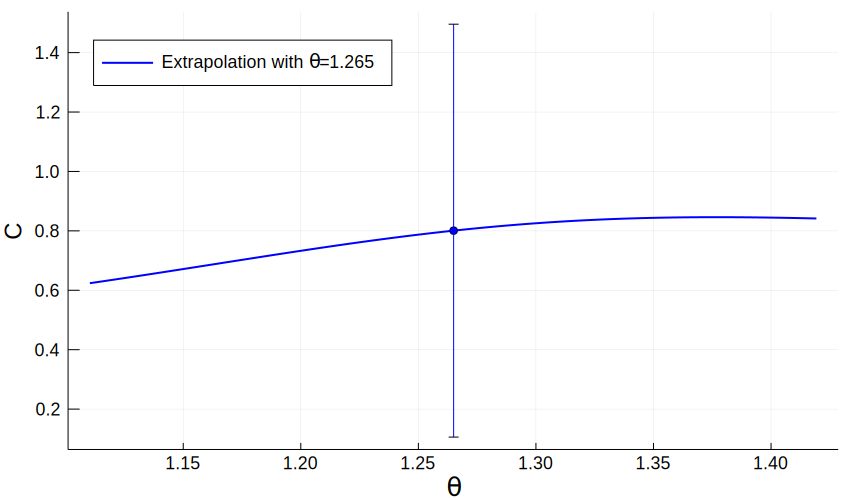

In [16]:
plot(extrapolation_thetas_1, new_C_1, label="Extrapolation with \\theta=$theta_1", 
    color="blue", lw=2, alpha=1, xlab="\\theta", ylab="C", xtickfont=font(12), 
    ytickfont=font(12), guidefont=font(16), legendfont=font(12), size=(850,500), legend = :topleft)

#plot!(extrapolation_thetas_2, new_kappa_2, label="Extrapolation with \\theta=$theta_2", color="red", linestyle= :dash, lw=2)

scatter!([theta_1], [init_C_val_1], yerr=init_C_err_1, color="blue", label="")
#scatter!([theta_2], [init_kappa_val_2], yerr=init_kappa_err_2/L, color="red", label="")

#savefig("two_point_ferrenberg_C")

In [10]:
#=
Ls = [50, 60, 70, 80, 90, 100]

xi = 0.05
theta = 0.0905

d_theta = 0.0001

extrapolate_Ls(Ls, xi, theta,  d_theta)
=#